# Packages

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from covid19model.models.base import BaseModel
from covid19model.data.utils import construct_initN
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.models.time_dependant_parameter_fncs import make_seasonality_function
from covid19model.data.sciensano import get_sciensano_COVID19_data
import csv
from csv import DictReader

# Data

In [7]:
abs_dir = os.getcwd()
rel_dir = '../../data/interim/QALY_model/postponement_non_covid_care/UZG/'

file_name = '2020_2021_normalized.csv'
types_dict = {'APR_MDC_key': str}
hospitalizations_normalized = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1],dtype=types_dict).squeeze()
hospitalizations_normalized.index = hospitalizations_normalized.index.set_levels([hospitalizations_normalized.index.levels[0], pd.to_datetime(hospitalizations_normalized.index.levels[1])])

file_name = 'MZG_baseline.csv'
types_dict = {'APR_MDC_key': str}
df_baseline = pd.read_csv(os.path.join(abs_dir,rel_dir,file_name),index_col=[0,1,2],dtype=types_dict).squeeze()
df_baseline = df_baseline['n_patients'].groupby(['APR_MDC_key','week_number','day_number']).mean()

covid_data, _ , _ , _ = get_sciensano_COVID19_data(update=False)
new_index = pd.MultiIndex.from_product([pd.to_datetime(hospitalizations_normalized.index.get_level_values('date').unique()),covid_data.index.get_level_values('NIS').unique()])
covid_data = covid_data.reindex(new_index,fill_value=0)
df_covid_H_in = covid_data['H_in'].loc[:,40000]
df_covid_H_tot = covid_data['H_tot'].loc[:,40000]
#df_covid_H_tot = df_covid_H_tot.ewm(7).mean()
df_covid_dH = df_covid_H_tot.copy()
for date in df_covid_dH.index.get_level_values('date').unique()[:-1]:
    df_covid_dH[date] = df_covid_H_tot[date+pd.Timedelta(days=1)]-df_covid_H_tot[date]
df_covid_dH[-1]=df_covid_dH[-2]
#df_covid_dH = df_covid_dH.ewm(14).mean()

MDC_dict={}
file_name = 'MDC_dict.csv'
with open(os.path.join(abs_dir,rel_dir,file_name), mode='r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        MDC_dict.update({row[0]:row[1]})

MDC_dict.pop('.')
MDC_keys = MDC_dict.keys()


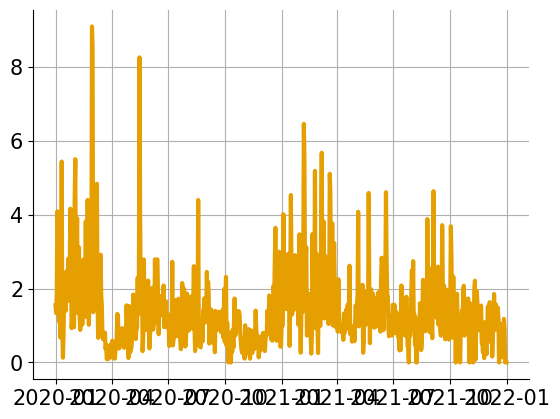

In [8]:
fig,ax = plt.subplots()
ax.plot(hospitalizations_normalized['mean'].loc['02'])

# Define model and functions

## models

In [9]:
class postponed_healthcare_model(BaseModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['H','E']
    parameter_names = ['alpha','beta','gamma','Ki','Kp','covid_H','covid_dH','covid_min']
    parameters_stratified_names = []
    stratification = ['MDC_keys']
    coordinates = [None]
    
    @staticmethod
    def integrate(t,H,E,alpha,beta,gamma, Ki,Kp, covid_H, covid_dH, covid_min, MDC_keys):

        epsilon = H-1
        dE = epsilon - gamma*E
        if covid_H < covid_min:
            u = Kp * np.where(E>=0,epsilon,0) + Ki * np.where(E<0,E,0)
            dH = alpha*covid_dH - beta*u
        else:
            dH = alpha*covid_dH

        return dH, dE

## time dependant functions

In [10]:
def hypothetical_covid_peak(t, states, param,MDC_keys,start_peak,end_peak,peak_amplitude):
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    return covid_H


In [11]:
def get_covid_hospitalizations(t,states,param,tau):
    t = pd.to_datetime(t).round(freq='D')-pd.Timedelta(days=tau)
    try:
        covid = df_covid_H_in.loc[t]
    except:
        covid = 0
    return covid

In [12]:
def get_covid_H(t,states,param,tau):
    t = pd.to_datetime(t).round(freq='D')-pd.Timedelta(days=tau)
    try:
        covid = df_covid_H_tot.loc[t]
    except:
        covid = 0
    return covid

In [13]:
def get_covid_dH(t,states,param,tau):
    t = pd.to_datetime(t).round(freq='D')-pd.Timedelta(days=tau)
    try:
        covid = df_covid_dH.loc[t]
    except:
        covid = 0

    return covid

In [14]:
def alpha_func(t,states,param):
    if t < pd.to_datetime('2020-08-06'):
        alpha = np.ones(len(MDC_classes))*-0.0011
        alpha[np.where(MDC_classes=='04')]=0.002
    else:
        alpha = np.ones(len(MDC_classes))*-0.0005
        alpha[np.where(MDC_classes=='04')]=0.002
    return alpha

In [15]:
def beta_func(t,states,param):
    if t < pd.to_datetime('2020-08-06'):
        beta = np.ones(len(MDC_classes))*0.01
        beta[np.where(MDC_classes=='04')]=0
    else:
        beta = np.ones(len(MDC_classes))*0.2
        beta[np.where(MDC_classes=='04')]=0
    return beta

In [16]:
def gamma_func(t,states,param):
    if t < pd.to_datetime('2020-08-06'):
        gamma = np.ones(len(MDC_classes))*0.1
        gamma[np.where(MDC_classes=='04')]=0.1
    else:
        gamma = np.ones(len(MDC_classes))*0.01
        gamma[np.where(MDC_classes=='04')]=0.01
    return gamma

# Conceptual example

## Parameters

In [17]:
#set start and end date of sim
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = np.array(['04','05'])

In [18]:
alpha = np.ones(len(MDC_classes))*-0.0005
alpha[np.where(MDC_classes=='04')]=0.001

beta = np.ones(len(MDC_classes))*0.1
beta[np.where(MDC_classes=='04')]=0

gamma = np.ones(len(MDC_classes))*0.03
gamma[np.where(MDC_classes=='04')]=0.03

Kp = np.ones(len(MDC_classes))*1
Ki = np.ones(len(MDC_classes))*0.05

covid_H = 0
covid_dH = 0
covid_min = 200

params={'alpha':alpha, 'beta':beta,'gamma':gamma,'Kp':Kp,'Ki':Ki,'covid_H':covid_H,'covid_dH':covid_dH,'covid_min':covid_min,'MDC_keys':MDC_classes}

#time dependent parameters
tau = 0
params.update({'tau':tau})

## Initialize model

In [19]:
init_states = {'H':np.ones(len(MDC_classes)),'E':np.zeros(len(MDC_classes))}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_dH': get_covid_dH,'covid_H': get_covid_H})

## Simulate model

In [20]:
out = model.sim(sim_len,start_date=start_date)

## Plot results

In [21]:
MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-03-01')
plot_end_date = pd.to_datetime('2020-10-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

### Covid

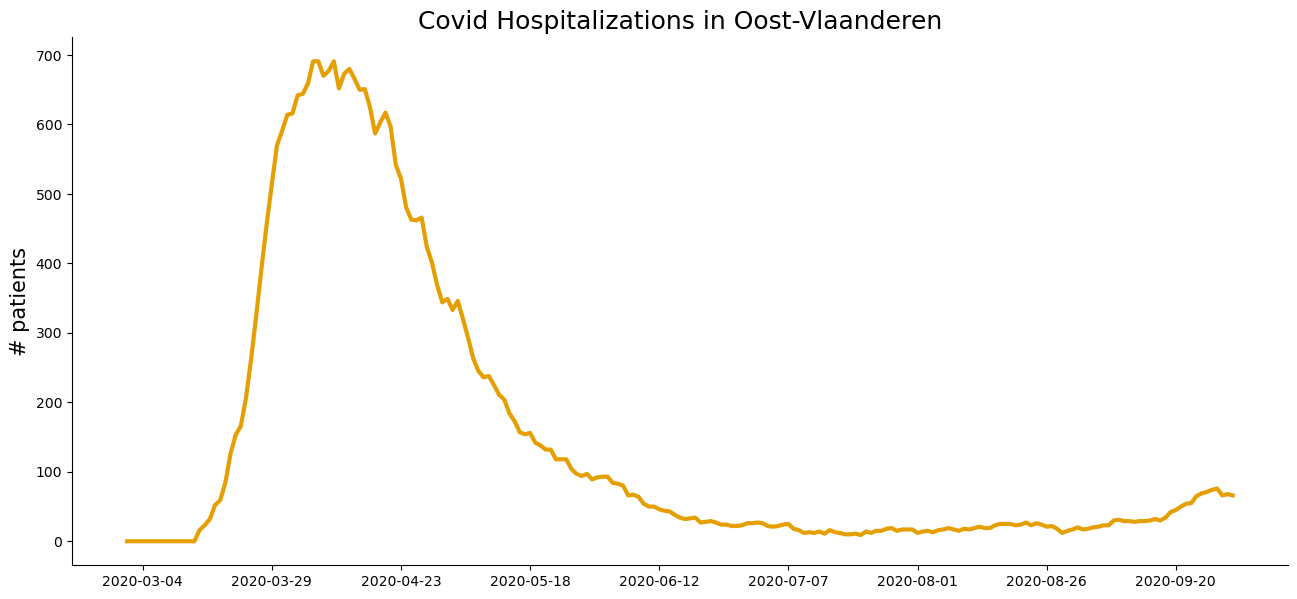

In [22]:
fig,ax = plt.subplots()
ax.set_title('Covid Hospitalizations in Oost-Vlaanderen')
ax.plot(plot_time,df_covid_H_tot.loc[plot_time])
ax.set_ylabel('# patients')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.1,
                    hspace=0.1)
plt.show()

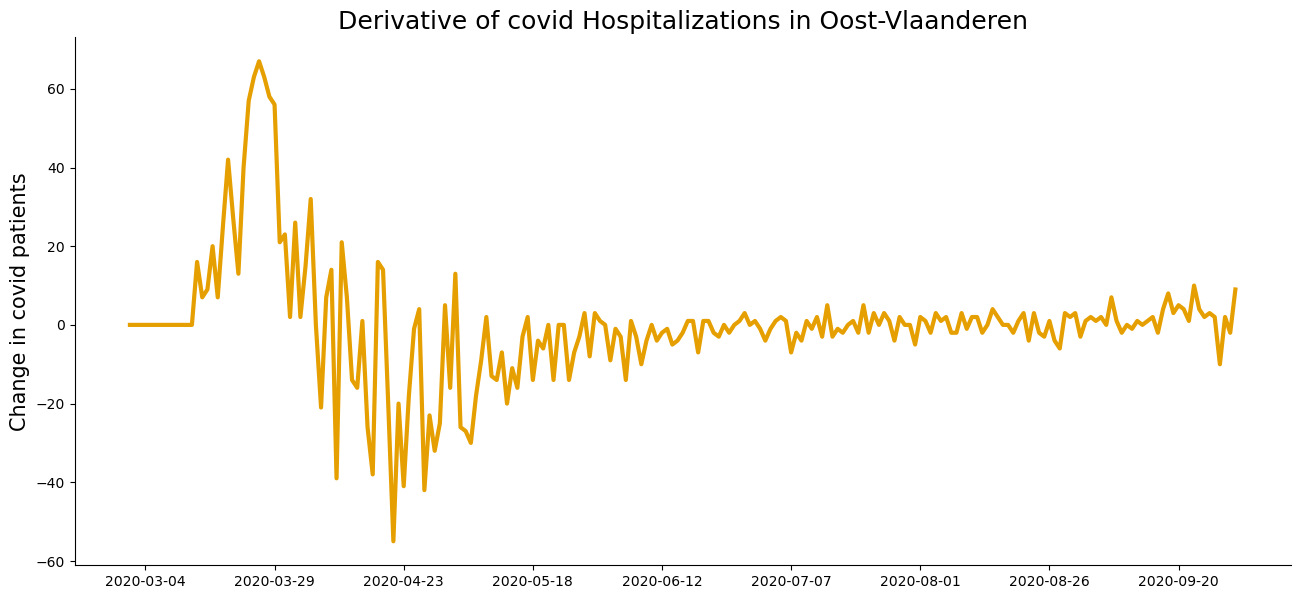

In [23]:
fig,ax = plt.subplots()
ax.set_title('Derivative of covid Hospitalizations in Oost-Vlaanderen')
ax.plot(plot_time,df_covid_dH.loc[plot_time])
ax.set_ylabel('Change in covid patients')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.1,
                    hspace=0.1)
plt.show()

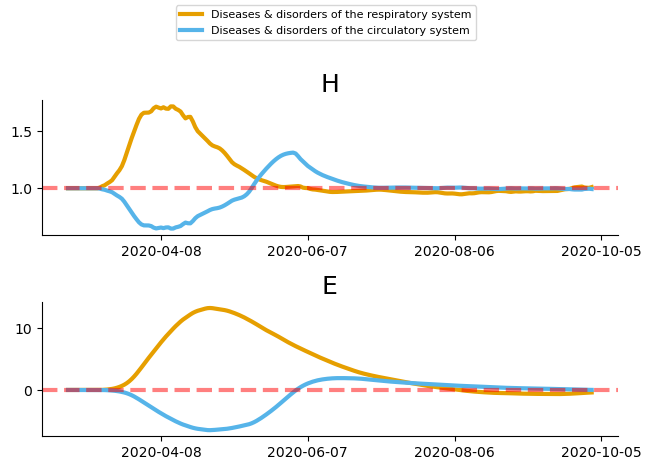

In [24]:
out_plot = out.sel(time=plot_time)
fig,axs = plt.subplots(2,1)
#for idx,state in enumerate(model.state_names):
for idx,state in enumerate(['H','E']):
    for disease in MDC_classes:
        axs[idx].plot(plot_time,out_plot.sel(MDC_keys=disease)[state],label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

axs[0].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 
axs[1].axhline(y = 0, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

# Parameter influences

In [25]:
#set start and end date of sim
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = np.array(['04','05'])

MDC_plot_classes = np.array(['05','04'])
plot_start_date = pd.to_datetime('2020-03-01')
plot_end_date = pd.to_datetime('2020-10-01')
plot_time = pd.date_range(plot_start_date,plot_end_date)

In [26]:
alpha = np.ones(len(MDC_classes))*-0.08
alpha[np.where(MDC_classes=='04')]=0.08

beta = np.ones(len(MDC_classes))*0.1
beta[np.where(MDC_classes=='04')]=0

gamma = np.ones(len(MDC_classes))*0.03
gamma[np.where(MDC_classes=='04')]=0.03

Kp = np.ones(len(MDC_classes))*2
Ki = np.ones(len(MDC_classes))*0.1

covid_H = 0
covid_dH = 0
covid_min = 200

params={'alpha':alpha, 'beta':beta,'gamma':gamma,'Kp':Kp,'Ki':Ki,'covid_H':covid_H,'covid_dH':covid_dH,'covid_min':covid_min,'MDC_keys':MDC_classes}

#time dependent parameters
tau = 0
params.update({'tau':tau})

## Alpha

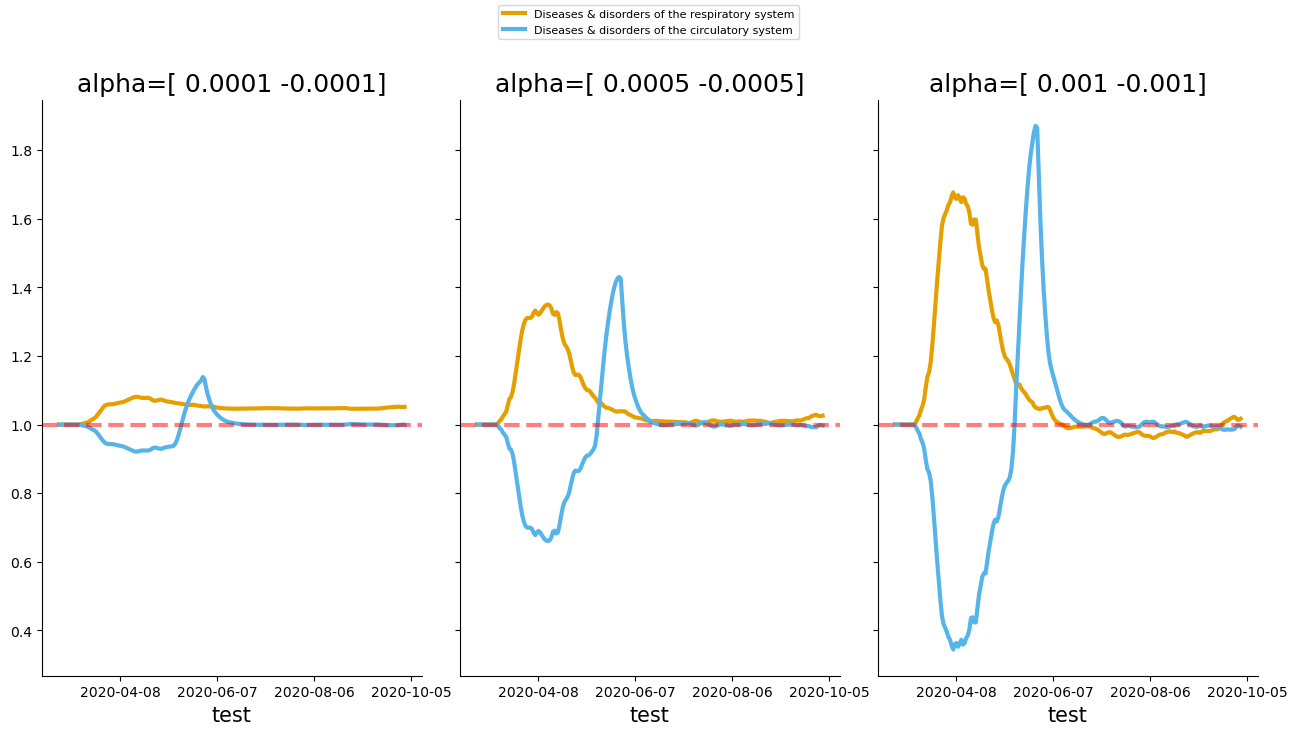

In [27]:
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_dH': get_covid_dH,'covid_H': get_covid_H})

alphas = np.array([[0.0001,-0.0001],[0.0005,-0.0005],[0.001,-0.001]])

fig,axs = plt.subplots(1,len(alphas),sharey=True)
for idx,alpha in enumerate(alphas):

    model.parameters.update({'alpha':alpha})
    out = model.sim(sim_len,start_date=start_date)
    out_plot = out.sel(time=plot_time)

    for disease in MDC_classes:
        axs[idx].plot(plot_time,out_plot.sel(MDC_keys=disease)['H'],label=MDC_dict[disease])
        axs[idx].set_title('alpha='+str(alpha))
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)
        axs[idx].set_xlabel('test')

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)

for idx in range(len(axs)):
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=-0.4,
                    right=2,
                    top=0.8,
                    wspace=0.1,
                    hspace=0.1)

plt.show()

## Beta

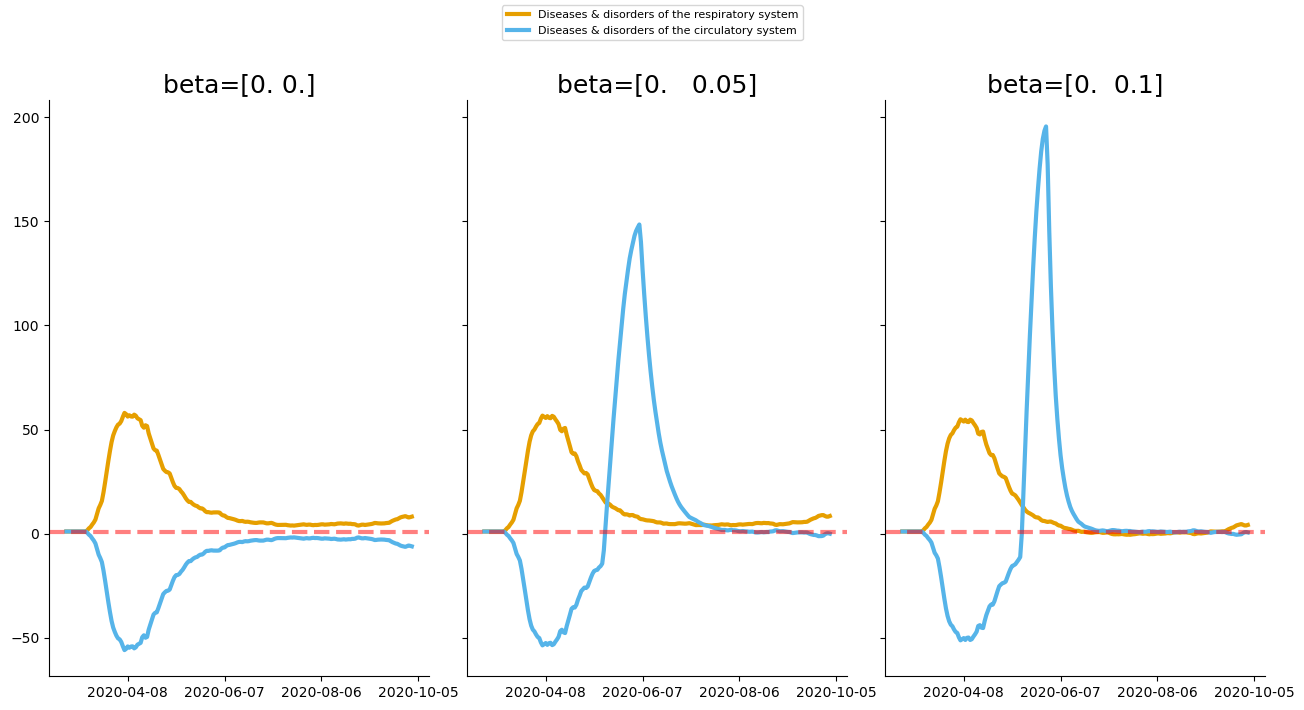

In [28]:
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_dH': get_covid_dH,'covid_H': get_covid_H})

gamma = 0
model.parameters.update({'gamma':gamma})
betas = np.array([[0,0],[0,0.05],[0,0.1]])

fig,axs = plt.subplots(1,len(alphas),sharey=True)
for idx,beta in enumerate(betas):

    model.parameters.update({'beta':beta})
    out = model.sim(sim_len,start_date=start_date)
    out_plot = out.sel(time=plot_time)

    for disease in MDC_classes:
        axs[idx].plot(plot_time,out_plot.sel(MDC_keys=disease)['H'],label=MDC_dict[disease])
        axs[idx].set_title('beta='+str(beta))
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)

for idx in range(len(axs)):
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=-0.4,
                    right=2,
                    top=0.8,
                    wspace=0.1,
                    hspace=0.1)

plt.show()

## Gamma

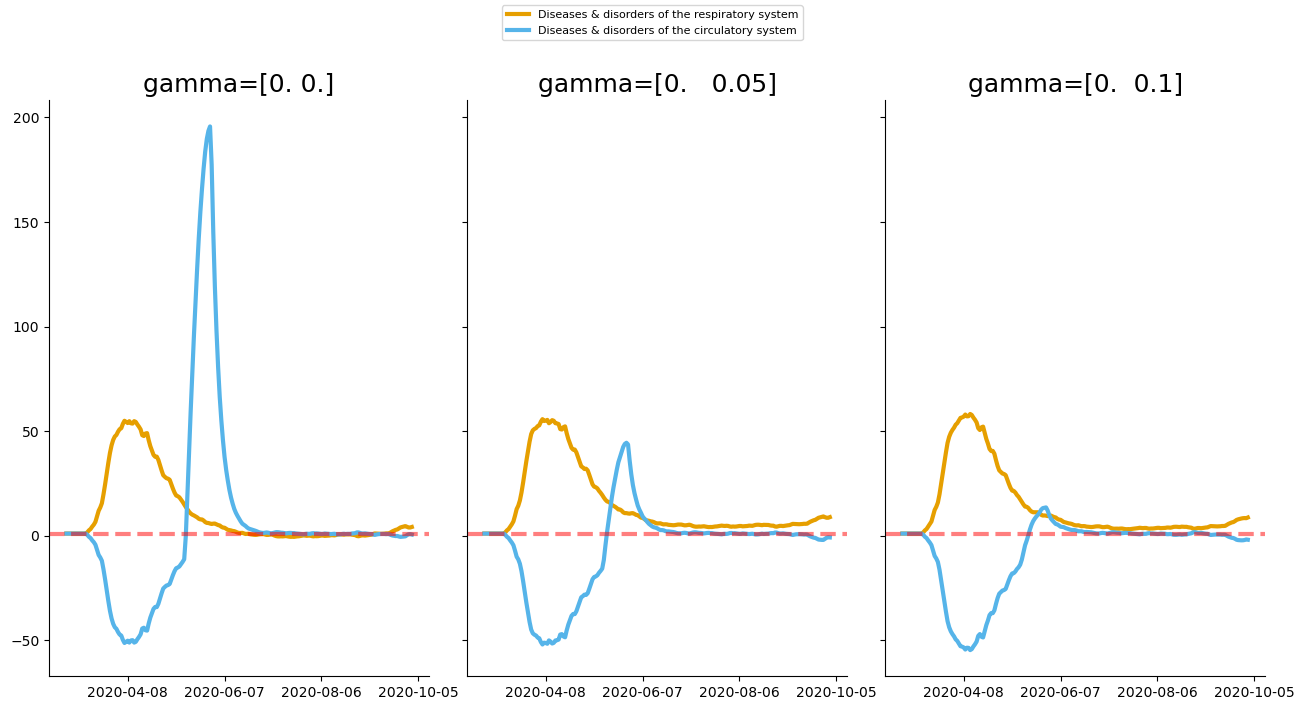

In [29]:
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_dH': get_covid_dH,'covid_H': get_covid_H})

gammas = np.array([[0,0],[0,0.05],[0,0.1]])

fig,axs = plt.subplots(1,len(gammas),sharey=True)
for idx,gamma in enumerate(gammas):

    model.parameters.update({'gamma':gamma})
    out = model.sim(sim_len,start_date=start_date)
    out_plot = out.sel(time=plot_time)

    for disease in MDC_classes:
        axs[idx].plot(plot_time,out_plot.sel(MDC_keys=disease)['H'],label=MDC_dict[disease])
        axs[idx].set_title('gamma='+str(gamma))
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)

for idx in range(len(axs)):
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=-0.4,
                    right=2,
                    top=0.8,
                    wspace=0.1,
                    hspace=0.1)

plt.show()

# Fitting Data

## Parameters

In [30]:
#set start and end date of sim
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2021-12-31')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

# Define MDC classes to model
MDC_classes = np.array(['04','05'])

In [31]:
alpha = np.ones(len(MDC_classes))*-0.0011
alpha[np.where(MDC_classes=='04')]=0.002

beta = np.ones(len(MDC_classes))*0.01
beta[np.where(MDC_classes=='04')]=0

gamma = np.ones(len(MDC_classes))*0.1
gamma[np.where(MDC_classes=='04')]=0.1

Kp = np.ones(len(MDC_classes))*1
Ki = np.ones(len(MDC_classes))*0.05

covid_H = 0
covid_dH = 0
covid_min = 400

params={'alpha':alpha, 'beta':beta,'gamma':gamma,'Kp':Kp,'Ki':Ki,'covid_H':covid_H,'covid_dH':covid_dH,'covid_min':covid_min,'MDC_keys':MDC_classes}

#time dependent parameters
tau = 0
params.update({'tau':tau})

## Initialize model

In [32]:
init_states = {'H':np.ones(len(MDC_classes)),'E':np.zeros(len(MDC_classes))}
coordinates=[MDC_classes,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'covid_dH': get_covid_dH,'covid_H':get_covid_H,'alpha':alpha_func,'gamma':gamma_func,'beta':beta_func})

## Simulate model

In [33]:
out = model.sim(sim_len,start_date=start_date)

## Plots

In [34]:
MDC_plot_classes = np.array(['04','05'])
plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2021-12-31')
plot_time = pd.date_range(plot_start_date,plot_end_date)

### Covid

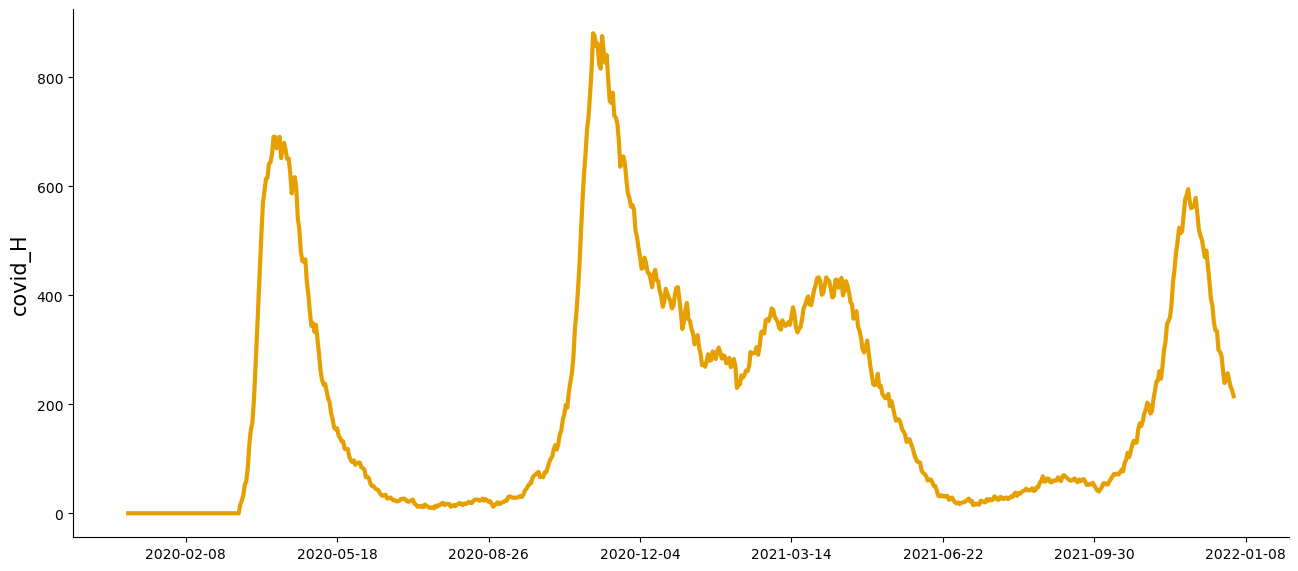

In [35]:
plot_covid_H_tot = df_covid_H_tot.reindex(plot_time,fill_value=0)
fig,ax = plt.subplots()
ax.plot(plot_time,plot_covid_H_tot)
ax.set_ylabel('covid_H')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.1,
                    hspace=0.1)
plt.show()

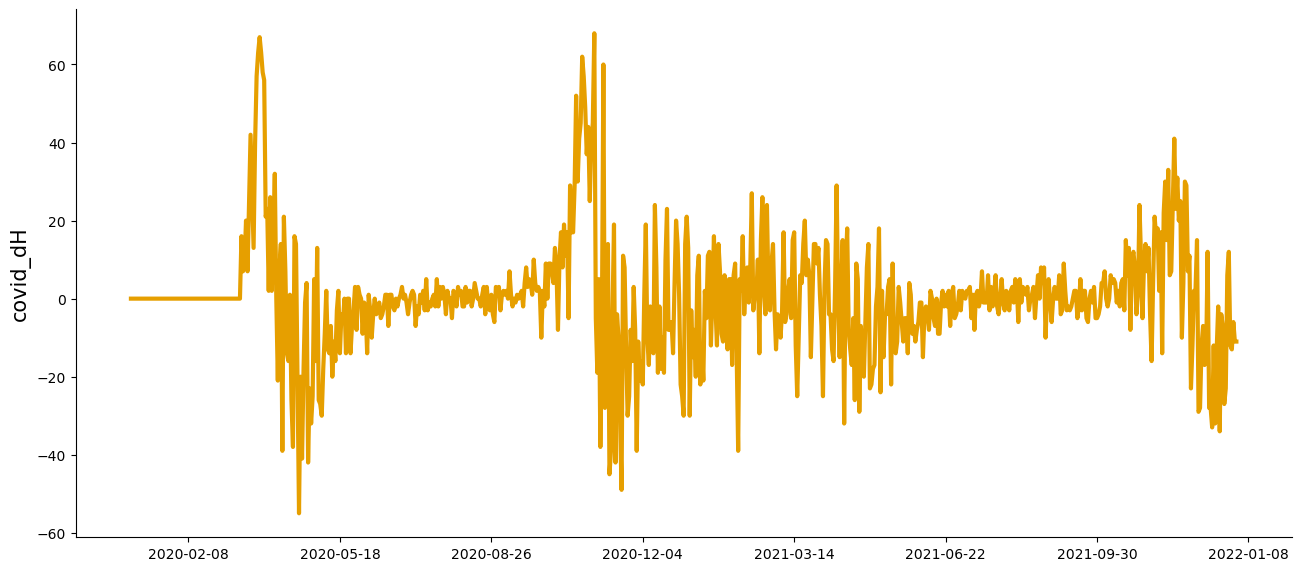

In [36]:
plot_covid_dH = df_covid_dH.reindex(plot_time,fill_value=0)
fig,ax = plt.subplots()
ax.plot(plot_time,plot_covid_dH)
ax.set_ylabel('covid_dH')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.grid(False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=1.2,
                    wspace=0.1,
                    hspace=0.1)
plt.show()

### results

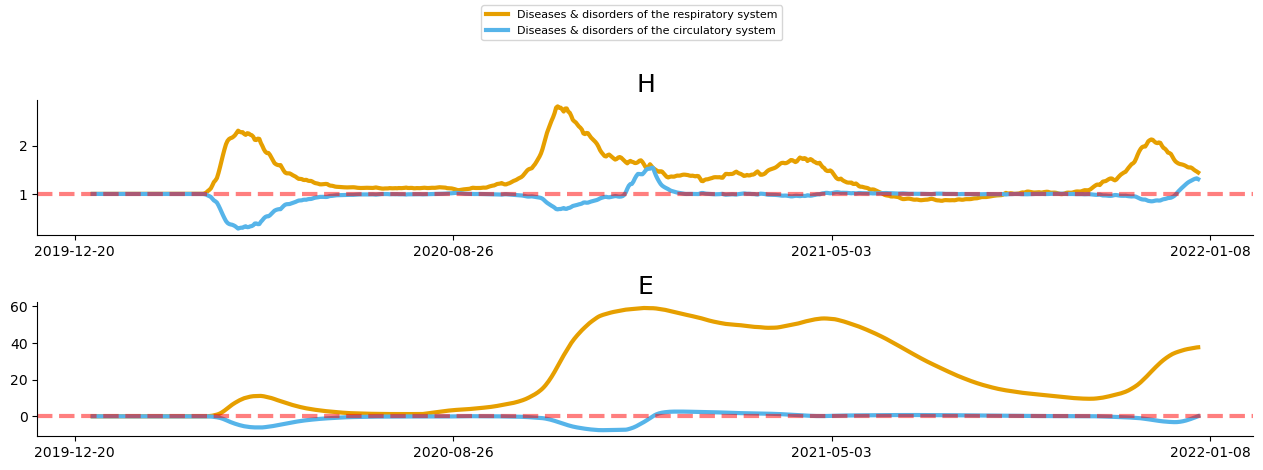

In [37]:
fig,axs = plt.subplots(2,1)

#for idx,state in enumerate(model.state_names):
for idx,state in enumerate(['H','E']):
    for disease in MDC_classes:
        axs[idx].plot(plot_time,out.sel(time=plot_time,MDC_keys=disease)[state],label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(4))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

axs[0].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 
axs[1].axhline(y = 0, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

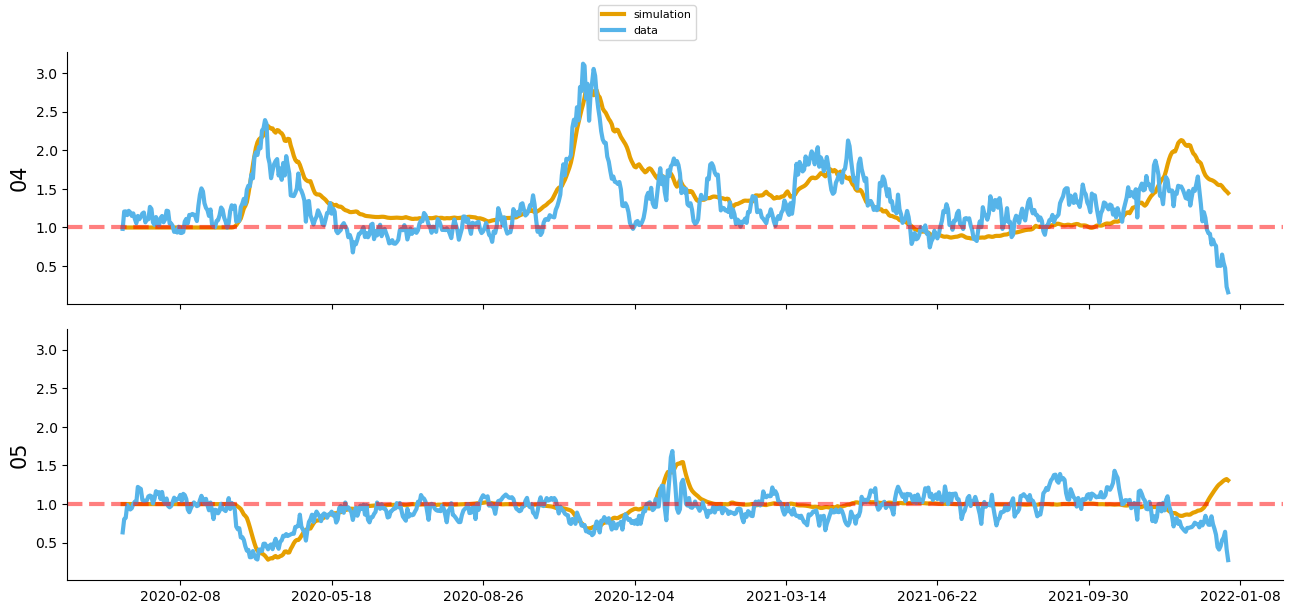

In [38]:
index = pd.MultiIndex.from_product([MDC_plot_classes,pd.to_datetime(plot_time)],names=['APR_MDC_key','date'])
data = hospitalizations_normalized.copy()
data = data.reindex(index=index)

fig,axs = plt.subplots(len(MDC_plot_classes),sharex=True,sharey=True)
axs = axs.reshape(-1)

for idx,disease in enumerate(MDC_plot_classes):
    axs[idx].plot(plot_time,out.sel(time=plot_time,MDC_keys=disease)['H'],label='simulation')
    axs[idx].plot(plot_time,data['median'].loc[disease,plot_time], label='data')
    axs[idx].set_ylabel(disease)
    axs[idx].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[idx].grid(False)
    axs[idx].tick_params(axis='both', which='major', labelsize=10)
    axs[idx].tick_params(axis='both', which='minor', labelsize=8)
    #axs[idx].tick_params('x', labelbottom=False)

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)

for idx in range(len(axs)):
    axs[idx].axhline(y = 1, color = 'r', linestyle = 'dashed', alpha=0.5) 

plt.subplots_adjust(left=0.1,
                    bottom=-0.2,
                    right=2,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)

plt.show()

# Calculating QALYs

In [39]:
time = pd.date_range(start_date,end_date)

In [40]:
index = pd.MultiIndex.from_product([MDC_keys,time])
baseline = pd.Series(index=index,dtype='float64')
for disease in MDC_keys:
    for date in plot_time:
        baseline.loc[disease,date]=df_baseline.loc[disease,date.isocalendar().week,date.isocalendar().weekday]
baseline = baseline.ewm(20).mean()

In [41]:
hospitalizations = out['H'].to_series()*baseline.loc[MDC_classes]

## Plots

In [42]:
MDC_plot_classes = np.array(['04','05'])
plot_start_date = pd.to_datetime('2020-01-01')
plot_end_date = pd.to_datetime('2021-12-31')
plot_time = pd.date_range(plot_start_date,plot_end_date)

In [43]:
baseline_plot = baseline.loc[MDC_plot_classes,plot_time]
hospitalizations_plot = hospitalizations.loc[MDC_plot_classes,plot_time]

baseline_plot.name = 'baseline H'
hospitalizations_plot.name = 'simulated H'

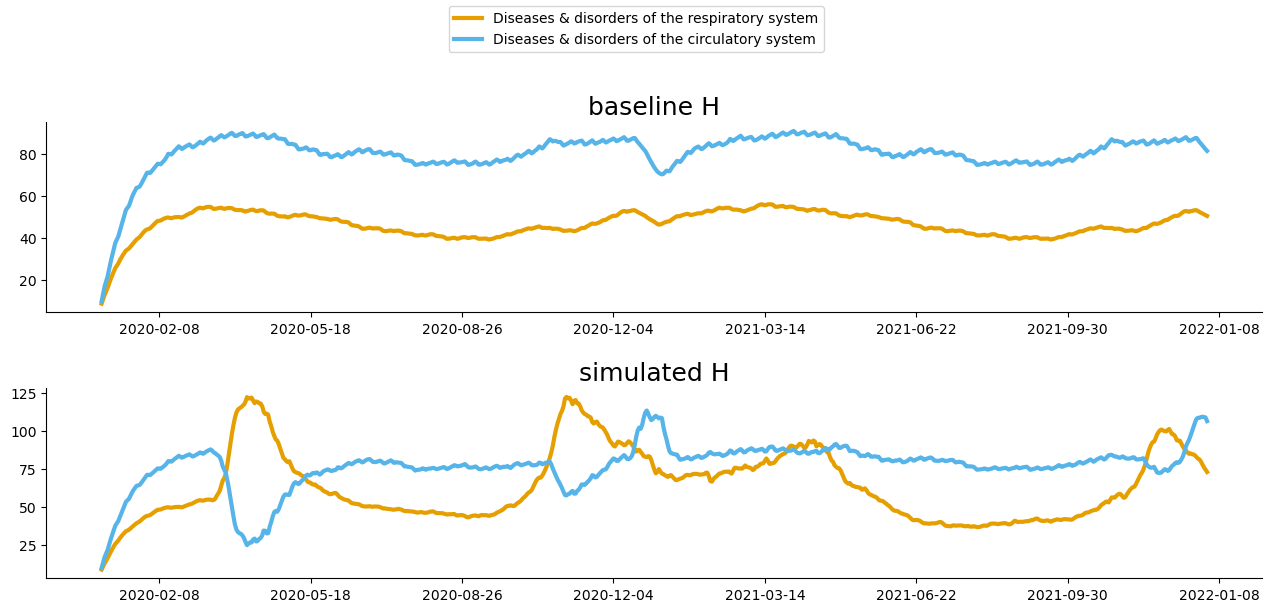

In [44]:
fig,axs = plt.subplots(2)
axs = axs.reshape(-1)

data_list = [baseline_plot,hospitalizations_plot]
for idx,data in enumerate(data_list):
    for disease in MDC_plot_classes:
        axs[idx].plot(plot_time,data.loc[disease,plot_time], label=MDC_dict[disease])
        axs[idx].set_title(data.name)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(10))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)
        #axs[idx].tick_params('x', labelbottom=False)

handles, labels = axs[idx].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=10)

plt.subplots_adjust(left=0.1,
                    bottom=-0.2,
                    right=2,
                    top=0.75,
                    wspace=0.3,
                    hspace=0.4)

plt.show()

go to threatend patients => divide by residence time? \
threatend patients * QALY_gain